In [25]:
!pip install rasterio
!pip install numpy
!pip install matplotlib
!pip install -U scikit-image
!pip install boto3
!pip install watermark
!pip install nb_black

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -

In [26]:
%matplotlib inline

In [27]:
%load_ext watermark

In [28]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [6]:
import rasterio
from rasterio.plot import show
import numpy
import matplotlib.pyplot as plt

import skimage.exposure

# access package for AWS access
import boto3

import sys
import os
import subprocess
import datetime
import platform
import datetime

In [2]:
# datasetGRAY = rasterio.open('https://s3-us-west-2.amazonaws.com/landsat-pds/L8/073/231/LC80732312016158LGN00/LC80732312016158LGN00_B1.TIF')

# datasetBLUE = rasterio.open('https://s3-us-west-2.amazonaws.com/landsat-pds/L8/073/231/LC80732312016158LGN00/LC80732312016158LGN00_B2.TIF')

# datasetGREEN = rasterio.open('https://s3-us-west-2.amazonaws.com/landsat-pds/L8/073/231/LC80732312016158LGN00/LC80732312016158LGN00_B3.TIF')

# datasetRED = rasterio.open('https://s3-us-west-2.amazonaws.com/landsat-pds/L8/073/231/LC80732312016158LGN00/LC80732312016158LGN00_B4.TIF')

datasetList = [
  'https://s3-us-west-2.amazonaws.com/landsat-pds/L8/073/231/LC80732312016158LGN00/LC80732312016158LGN00_B1.TIF',
  'https://s3-us-west-2.amazonaws.com/landsat-pds/L8/073/231/LC80732312016158LGN00/LC80732312016158LGN00_B2.TIF',
  'https://s3-us-west-2.amazonaws.com/landsat-pds/L8/073/231/LC80732312016158LGN00/LC80732312016158LGN00_B3.TIF'
]

fpath = 'https://s3-us-west-2.amazonaws.com/landsat-pds/L8/073/231/LC80732312016158LGN00/LC80732312016158LGN00_B4.TIF'

In [8]:
src_image = rasterio.open(fpath)

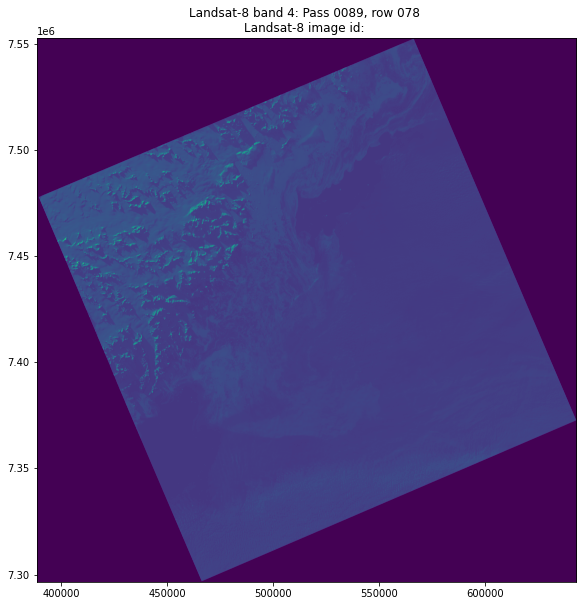

In [9]:
fig, ax = plt.subplots(1, figsize=(12, 10))
show(src_image, ax=ax)
ax.set_title(
    'Landsat-8 band 4: Pass 0089, row 078 \nLandsat-8 image id: '
)
plt.show()

In [10]:
# convert image to numpy

src_image_array = src_image.read(1)
src_image_array = src_image_array.astype('f4')

# replace zero items (ie array pixels out of image frame) with nan

src_image_array[src_image_array == 0] = numpy.nan

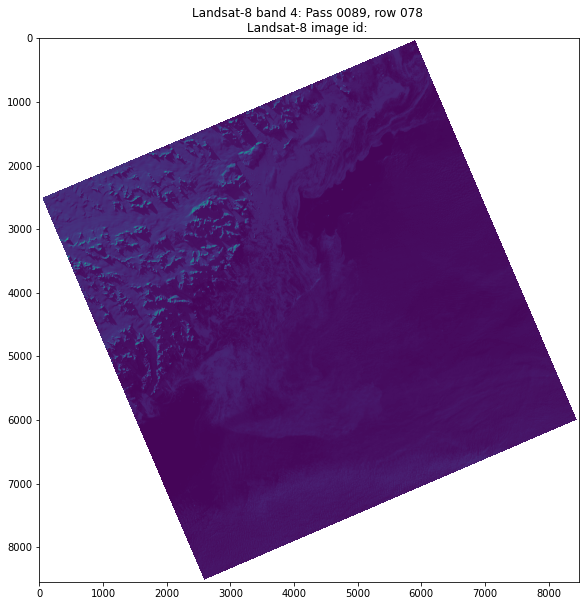

In [11]:
fig, ax = plt.subplots(1, figsize=(12, 10))
show(src_image_array, ax=ax)
ax.set_title(
    'Landsat-8 band 4: Pass 0089, row 078 \nLandsat-8 image id: '
)
plt.show()

In [12]:
# clean up big data objects

src_image_array = 0
src_image = 0

In [13]:
def normalize(array):
    '''
    normalize: normalize a numpy array so all value are between 0 and 1
    '''
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)


# end normalize

In [14]:
def make_color_image(b1: int, b2: int, b3: int, fpath: str):
    '''
    make_false_color_image: combine nominated Landsat-8 bands into false color image
    
    Parameters:
    b1, b2, b3 int - values between 1 - 6 (inclusive), being a Landsat-8 band number
    
    fpath str - template for URL to Landsat-8 data
    
    Band Number Description       Wavelength Resolution
    Band 1      Coastal / Aerosol 0.433 to 0.453 µm 30 meter
    Band 2      Visible blue      0.450 to 0.515 µm 30 meter
    Band 3      Visible green     0.525 to 0.600 µm 30 meter
    Band 4      Visible red       0.630 to 0.680 µm 30 meter
    Band 5      Near-infrared     0.845 to 0.885 µm 0 meter
    Band 6      Short wavelength infrared 1.56 to 1.66 µm 30 meter
    
    Environment:
    assumes rasterio imported as rio
    assumes boto package  available for AWS file storage access
    '''

    if not (
        b1 > 0
        and b2 > 0
        and b3 > 0
        and b1 < 7
        and b2 < 7
        and b3 < 7
    ):
        raise ValueError(
            f'One or more invalid Landsat-8 band number {b1}, {b2}, {b3} supplied'
        )
    # endif

    # create URLs for each band
    b1_path = fpath[:-5] + f'{b1}.TIF'
    b2_path = fpath[:-5] + f'{b2}.TIF'
    b3_path = fpath[:-5] + f'{b3}.TIF'
    print(b1_path)

    # open URL with rasterio
    b1 = rasterio.open(b1_path)
    b2 = rasterio.open(b2_path)
    b3 = rasterio.open(b3_path)

    # read into numpy array
    b1_np = b1.read(1)
    b2_np = b2.read(1)
    b3_np = b3.read(1)

    # normalize data to 0<->1
    b1_norm = normalize(b1_np)
    b2_norm = normalize(b2_np)
    b3_norm = normalize(b3_np)

    # create three color image
    rgb = numpy.dstack((b1_norm, b2_norm, b3_norm))

    return rgb


# end make_color_image

In [15]:
# read true color image
rbg = make_color_image(4, 3, 2, fpath)

https://s3-us-west-2.amazonaws.com/landsat-pds/L8/073/231/LC80732312016158LGN00/LC80732312016158LGN00_B4.TIF


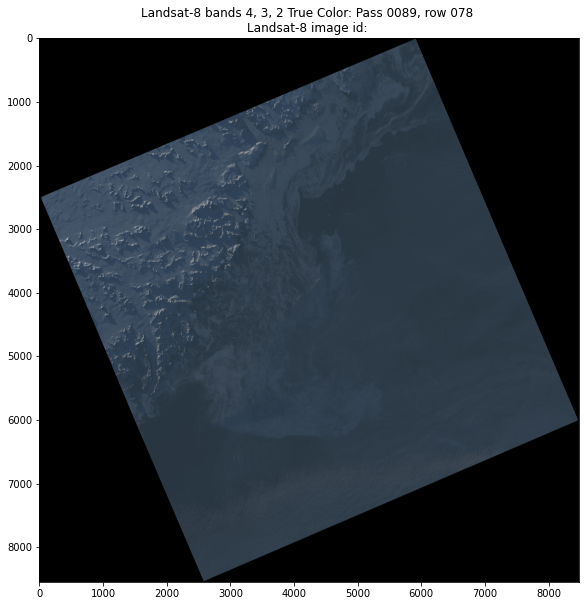

In [16]:
fig, ax = plt.subplots(1, figsize=(12, 10))
ax.set_title(
    'Landsat-8 bands 4, 3, 2 True Color: Pass 0089, row 078 \nLandsat-8 image id: ')
plt.imshow(rbg)

In [19]:
def make_color_image_eqh(
    b1: int, b2: int, b3: int, fpath: str
):
    '''
    make_false_color_image: combine nominated Landsat-8 bands into false color image
    
    Parameters:
    b1, b2, b3 int - values between 1 - 6 (inclusive), being a Landsat-8 band number
    
    fpath str - template for URL to Landsat-8 data
    
    Band Number Description       Wavelength Resolution
    Band 1      Coastal / Aerosol 0.433 to 0.453 µm 30 meter
    Band 2      Visible blue      0.450 to 0.515 µm 30 meter
    Band 3      Visible green     0.525 to 0.600 µm 30 meter
    Band 4      Visible red       0.630 to 0.680 µm 30 meter
    Band 5      Near-infrared     0.845 to 0.885 µm 0 meter
    Band 6      Short wavelength infrared 1.56 to 1.66 µm 30 meter
    '''

    if not (
        b1 > 0
        and b2 > 0
        and b3 > 0
        and b1 < 7
        and b2 < 7
        and b3 < 7
    ):
        raise ValueError(
            f'One or more invalid Landsat-8 band number {b1}, {b2}, {b3} supplied'
        )
    # endif

    # create URLs for each band
    b1_path = fpath[:-5] + f'{b1}.TIF'
    b2_path = fpath[:-5] + f'{b2}.TIF'
    b3_path = fpath[:-5] + f'{b3}.TIF'

    # open URL with rasterio
    b1 = rasterio.open(b1_path)
    b2 = rasterio.open(b2_path)
    b3 = rasterio.open(b3_path)

    # read into numpy array
    b1_np = b1.read(1)
    b2_np = b2.read(1)
    b3_np = b3.read(1)

    eq_b1 = skimage.exposure.equalize_hist(b1_np)
    eq_b2 = skimage.exposure.equalize_hist(b2_np)
    eq_b3 = skimage.exposure.equalize_hist(b2_np)

    # normalize data to 0<->1
    b1_norm = normalize(eq_b1)
    b2_norm = normalize(eq_b2)
    b3_norm = normalize(eq_b3)

    # create three color image
    rgb = numpy.dstack((b1_norm, b2_norm, b3_norm))

    return rgb

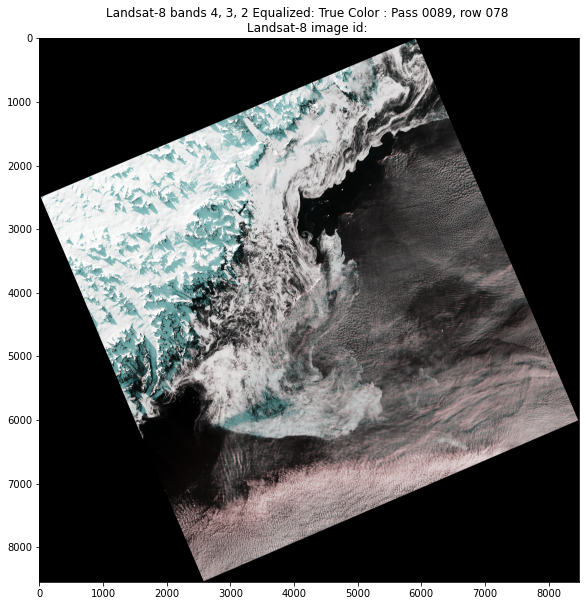

In [20]:
rgb = make_color_image_eqh(4, 3, 2, fpath)

fig, ax = plt.subplots(1, figsize=(12, 10))
ax.set_title(
    'Landsat-8 bands 4, 3, 2 Equalized: True Color : Pass 0089, row 078 \nLandsat-8 image id: '
)

plt.imshow(rgb)

In [5]:
print(fpath[:-5])

https://s3-us-west-2.amazonaws.com/landsat-pds/L8/073/231/LC80732312016158LGN00/LC80732312016158LGN00_B


In [29]:
%watermark

Last updated: 2021-10-27T09:05:14.487440-03:00

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.28.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.11.0-38-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit



<IPython.core.display.Javascript object>

In [30]:
%watermark -h -iv

Hostname: gabriel-H170M-D3H

matplotlib: 3.4.3
platform  : 1.0.8
boto3     : 1.19.4
sys       : 3.8.10 (default, Sep 28 2021, 16:10:42) 
[GCC 9.3.0]
skimage   : 0.18.3
numpy     : 1.17.4
rasterio  : 1.2.10



<IPython.core.display.Javascript object>